# Ejercicio 1
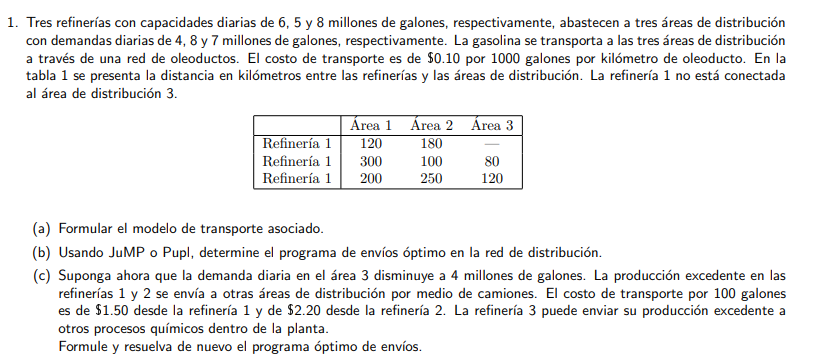

## B

In [4]:
using JuMP
using GLPK

# Conjuntos
I = 1:3
J = 1:3

# Oferta (miles de galones)
supply = Dict(1=>6000, 2=>5000, 3=>8000)
# Demanda (miles de galones)
demand = Dict(1=>4000, 2=>8000, 3=>7000)

# Distancias (km), Inf = sin conexión
distance = Dict(
    (1,1)=>120, (1,2)=>180, (1,3)=>Inf,
    (2,1)=>300, (2,2)=>100, (2,3)=>80,
    (3,1)=>200, (3,2)=>250, (3,3)=>120
)

A = [(i,j) for i in I, j in J if isfinite(distance[(i,j)])]
cost = Dict( (i,j)=>0.1*distance[(i,j)] for (i,j) in A )

# Modelo
model = Model(GLPK.Optimizer)

@variable(model, x[a in A] >= 0)

# Restricciones de oferta
for i in I
    @constraint(model,
        sum(x[(i,j)] for j in J if (i,j) in A) == supply[i]
    )
end

# Restricciones de demanda
for j in J
    @constraint(model,
        sum(x[(i,j)] for i in I if (i,j) in A) == demand[j]
    )
end

@objective(model, Min,
    sum(cost[a] * x[a] for a in A)
)

optimize!(model)

println("Costo óptimo: \$", objective_value(model))
for (i,j) in A
    q = value(x[(i,j)])
    if q > 1e-6
        println("Enviar ", q, " miles gal. de ref. ", i, " → área ", j)
    end
end


Costo óptimo: $243000.0
Enviar 4000.0 miles gal. de ref. 1 → área 1
Enviar 2000.0 miles gal. de ref. 1 → área 2
Enviar 5000.0 miles gal. de ref. 2 → área 2
Enviar 1000.0 miles gal. de ref. 3 → área 2
Enviar 7000.0 miles gal. de ref. 3 → área 3


## C

In [6]:
# Conjuntos
I = 1:3
J = 1:3

# Oferta
supply = Dict(1=>6000, 2=>5000, 3=>8000)
# Nueva demanda
demand = Dict(1=>4000, 2=>8000, 3=>4000)

# Distancias (km)
distance = Dict(
    (1,1)=>120, (1,2)=>180, (1,3)=>Inf,
    (2,1)=>300, (2,2)=>100, (2,3)=>80,
    (3,1)=>200, (3,2)=>250, (3,3)=>120
)

# Arcos válidos
A = [(i,j) for i in I, j in J if isfinite(distance[(i,j)])]
# Costo tubería $/mil gal
cost_pipe = Dict( (i,j)=>0.1*distance[(i,j)] for (i,j) in A )
# Costo camión $/mil gal para i=1,2
truck_cost = Dict(1=>15.0, 2=>22.0)

model2 = Model(GLPK.Optimizer)

@variable(model2, x[a in A] >= 0)
@variable(model2, y[i in 1:2] >= 0)

# Oferta para 1 y 2: tubería + camión = capacidad
for i in 1:2
    @constraint(model2,
        sum(x[(i,j)] for j in J if (i,j) in A) + y[i] == supply[i]
    )
end
# Refinería 3: solo tubería ≤ capacidad
@constraint(model2,
    sum(x[(3,j)] for j in J if (3,j) in A) <= supply[3]
)

# Demanda
for j in J
    @constraint(model2,
        sum(x[(i,j)] for i in I if (i,j) in A) == demand[j]
    )
end

@objective(model2, Min,
    sum(cost_pipe[a] * x[a] for a in A) +
    sum(truck_cost[i] * y[i] for i in 1:2)
)

optimize!(model2)

println("Costo óptimo (con camión): \$", objective_value(model2))
for (i,j) in A
    q = value(x[(i,j)])
    if q > 1e-6
        println("Tubería: enviar ", q, " miles gal. de ref. ", i, " → área ", j)
    end
end
for i in 1:2
    t = value(y[i])
    if t > 1e-6
        println("Camión (excedente ref. $i): ", t, " miles gal.")
    end
end

Costo óptimo (con camión): $207000.0
Tubería: enviar 4000.0 miles gal. de ref. 1 → área 1
Tubería: enviar 2000.0 miles gal. de ref. 1 → área 2
Tubería: enviar 5000.0 miles gal. de ref. 2 → área 2
Tubería: enviar 1000.0 miles gal. de ref. 3 → área 2
Tubería: enviar 4000.0 miles gal. de ref. 3 → área 3


# Ejercicio 2

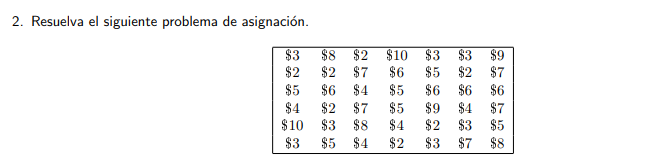

In [9]:
# trabajadores (6 filas)
I = 1:6

# tareas (7 columnas)
J = 1:7

# Matriz de costos: cada fila i y columna j es el costo de asignar i→j
cost = [
    3   8   2  10   3   3   9;
    2   2   7   6   5   2   7;
    5   6   4   5   6   6   6;
    4   2   7   5   9   4   7;
   10   3   8   4   2   3   5;
    3   5   4   2   3   7   8
]

model = Model(GLPK.Optimizer)

# Variable binaria x[i,j] = 1 si el trabajador i hace la tarea j, 0 en caso contrario
@variable(model, x[i in I, j in J], Bin)

# Restricción: cada trabajador i debe hacer exactamente una tarea
@constraint(model, [i in I], sum(x[i,j] for j in J) == 1)

# Restricción: cada tarea j es hecha por como máximo un trabajador
@constraint(model, [j in J], sum(x[i,j] for i in I) <= 1)

# Objetivo: minimizar el costo total de las asignaciones
@objective(model, Min, sum(cost[i,j] * x[i,j] for i in I, j in J))

optimize!(model)

println("Costo total óptimo: ", objective_value(model))
for i in I, j in J
    if value(x[i,j]) > 0.5
        println("Trabajador ", i,
                " → Tarea ", j,
                "  (costo = ", cost[i,j], ")")
    end
end

Costo total óptimo: 15.0
Trabajador 1 → Tarea 1  (costo = 3)
Trabajador 2 → Tarea 6  (costo = 2)
Trabajador 3 → Tarea 3  (costo = 4)
Trabajador 4 → Tarea 2  (costo = 2)
Trabajador 5 → Tarea 5  (costo = 2)
Trabajador 6 → Tarea 4  (costo = 2)


# Ejercicio 3

# Ejercicio 4

Implementar en Python los tres algoritmos vistos en clase para hallar los ceros de una función `f : [a, b] → ℝ`:

- método de bisección  
- método de la secante  
- método de Newton‑Raphson  

Como parámetros, sus algoritmos deben recibir la función `f`, la derivada `df` (en el caso de Newton), el intervalo `[a, b]` o el punto inicial de búsqueda `x0 ∈ ℝ`. Así como los criterios de paro `iter` y `tol > 0`.  

Para la salida, sus funciones deben devolver la lista de aproximaciones realizadas y el valor de punto `x*` donde se encontró el cero.


In [ ]:
def metodo_biseccion(f, a, b, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f en el intervalo [a, b] usando el método de bisección.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - a, b: extremos del intervalo [a, b]
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    if f(a) * f(b) >= 0:
        raise ValueError("La función debe cambiar de signo en el intervalo [a, b]")
    
    aproximaciones = []
    for _ in range(iter_max):
        c = (a + b) / 2
        aproximaciones.append(c)
        
        if abs(f(c)) < tol:
            break
            
        if f(a) * f(c) < 0:
            b = c
        else:
            a = c
    
    return aproximaciones, aproximaciones[-1]

In [ ]:
def metodo_secante(f, x0, x1, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de la secante.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - x0, x1: aproximaciones iniciales
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0, x1]
    
    for _ in range(iter_max):
        fx0 = f(x0)
        fx1 = f(x1)
        
        if abs(fx1) < tol:
            break
            
        x_next = x1 - fx1 * (x1 - x0) / (fx1 - fx0)
        aproximaciones.append(x_next)
        
        x0, x1 = x1, x_next
    
    return aproximaciones, aproximaciones[-1]

In [ ]:
def metodo_newton(f, df, x0, tol=1e-6, iter_max=100):
    """
    Encuentra un cero de la función f usando el método de Newton-Raphson.
    
    Parámetros:
    - f: función a la que se le busca el cero
    - df: derivada de la función f
    - x0: aproximación inicial
    - tol: tolerancia para el criterio de parada
    - iter_max: número máximo de iteraciones permitidas
    
    Retorna:
    - aproximaciones: lista de aproximaciones generadas
    - x: aproximación final del cero
    """
    aproximaciones = [x0]
    
    for _ in range(iter_max):
        fx = f(x0)
        dfx = df(x0)
        
        if abs(fx) < tol:
            break
            
        x_next = x0 - fx / dfx
        aproximaciones.append(x_next)
        
        x0 = x_next
    
    return aproximaciones, aproximaciones[-1]

# Ejercicio 5

# Ejercicio 6

# Ejercicio 7

# Ejercicio 8